# Air Quality - Model

Approach:
1. Different input variable have different ranges, this may lead to bias in the model. We first normalise the data
2. We then split the dataset into train andtest data
3. We consider 6 different algorithms (Linear Regression, Lasso, Elastic Net, K Nearest Neighbour,  Decision Tree/Random Forest and SVM to find out best performing models
4. Next we shall reduce dimentionality of the model. We may use Principal Component Analysis(PCA) or Recursive Feature Elimination(RFE). RFE gave a good result, hence, I used RFE
5. Now, we have best performing model, best performing features and normalised predictor variables. We now do detailed analysis with top 3 algorithms and compare result

In [74]:
import os
os.chdir('E:/Anupam/HomeDocs/DataScience/UpX-Academy/MachineLearning/Project/Air_Quality/')
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cross_validation import train_test_split

In [76]:
air_quality = pd.read_csv ('Air_Quality_EDA.csv')
air_quality.RH = round(air_quality.RH, 1)
air_quality.sample(5)

,Record_Hour,NMHC(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,DateOfMonth,Weekday,Weekend,Temp_Bin,dNMHC,dNOx,dNO2
0,18.0,150.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,10,2,0,4,38.0,63.0,21.0
9308,14.0,275.0,112.0,1022.0,80.0,853.0,382.0,22.0,20.2,0.5274,4,2,5,1,6,0.0,0.0,-1.0
1843,13.0,275.0,127.0,1128.0,112.0,1449.0,1060.0,31.6,16.4,0.7489,5,26,2,0,8,0.0,-1.0,0.0
5957,23.0,275.0,93.0,1136.0,52.0,1026.0,506.0,13.3,53.0,0.8044,11,13,5,1,4,0.0,-7.0,-5.0
3783,9.0,275.0,61.0,841.0,59.0,1562.0,759.0,26.3,50.1,1.6889,8,15,6,1,7,0.0,15.0,3.0


### Data Normalization

In [77]:
# Normalize the data
from sklearn import preprocessing
# Drop the target variable, ID, and non-relevant features
air_quality_normalized = air_quality.drop(['RH'], axis=1)
air_quality_normalized = pd.DataFrame(preprocessing.scale(air_quality_normalized), columns = air_quality_normalized.columns)


Scaling is giving a good result, hence I go with scaling. Alternately, Standard Scaler or Min Max Scaler can also be used

### Split the dataset into Test & Train

In [78]:
# Split the data into train and test data
feature_cols = air_quality.drop(['RH'], axis = 1).columns
X = air_quality_normalized [feature_cols]
y = air_quality.RH
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6345, 17)

(3126, 17)

(6345,)

(3126,)

### Model Comparison & Selection

In [79]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import naive_bayes
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [80]:
#Build the Model
MLA = [
    LinearRegression(),
    Lasso(),
    ElasticNet(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    SVR(),
#    naive_bayes.BernoulliNB(),
    ]

MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


In [81]:
row_index = 0
for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'Algorithm Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(metrics.r2_score(y_test, predicted), 4)
    MLA_compare.loc[row_index, 'RMSE'] = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    row_index = row_index  + 1
MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,Algorithm Name,Train Accuracy,Test Accuracy,RMSE
4,DecisionTreeRegressor,1.0000,0.9931,1.463429
5,SVR,0.9229,0.9184,5.041070
0,LinearRegression,0.8750,0.8742,6.258046
1,Lasso,0.8489,0.8481,6.876308
3,KNeighborsRegressor,0.9034,0.8426,6.999772
2,ElasticNet,0.6751,0.6750,10.057553


#### Inference
The K Nearest Neighbour, SVM and Decision Tree provides best accuracy on test data and lowerst RMSE value. Thus we shall do mode detailed implementation of these three algorithms

### Dimentionality Reduction - Recursive Feature Elemination

In [82]:
# Feature Extraction with Recursive feature elimination (RFE)
from sklearn.feature_selection import RFE

In [83]:
#Drop all object columns and keep the numeric  ones
predictors = X_train
#Output variable
y = y_train

In [84]:
# feature extraction
model = DecisionTreeRegressor()
rfe = RFE(model, 2)

In [85]:
feature_importance = rfe.fit(predictors.values, y)
print("Num Features: %" , feature_importance.n_features_)
print("Selected Features: %s", feature_importance.support_)
print("Feature Ranking: %s", feature_importance.ranking_)

Num Features: % 2
Selected Features: %s [False False False False False False False  True  True False False False
 False False False False False]
Feature Ranking: %s [ 2 14 10 11  6  3  8  1  1 13  7  4 15 12 16  5  9]


### Which are the 2-3 most important factors that determines Relative Humidity?

In [86]:
#Print all columns whose priority == 1
feature_cols = predictors.columns[np.nonzero(feature_importance.ranking_ == 1)]
feature_cols

Index(['T', 'AH'], dtype='object')

In [87]:
X_train = X_train[predictors.columns[np.nonzero(feature_importance.ranking_ == 1)]]
X_test = X_test[predictors.columns[np.nonzero(feature_importance.ranking_ == 1)]]
X_train.head()

,T,AH
6875,-1.495142,-1.494896
9157,-0.313300,0.440171
565,-0.574669,-0.182063
4358,0.521428,-0.232302
291,-0.438303,-0.484757


I performed multiple iteration from 2 features to 10 features. The test accuracy is best with 2 features. Thus, I go ahead with 2 features for detailed implementation in the 3 algorithms

### Decision Tree

In [88]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

Run the gridsearch to find best hyper parameters

In [89]:
params = {"max_depth": np.arange(3,10), "min_samples_split": np.arange(5,15)}
model = tree.DecisionTreeRegressor()
grid = GridSearchCV(estimator = model,  param_grid = params, cv  =  10)
grid_model = grid.fit(X_train, y_train)
grid_model.best_params_

{'max_depth': 9, 'min_samples_split': 5}

In [90]:
#Building the decision tree
model = tree.DecisionTreeRegressor(max_depth = 9, min_samples_split = 5, random_state = 123)
model = model.fit(X_train, y_train)

In [91]:
#Predicting the value
y_pred = model.predict(X_test)

In [92]:
#Accuracy of Model
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9902761493511477
0.9852361483867574


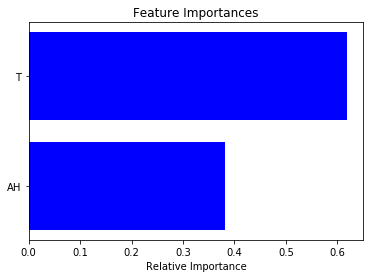

[('T', 0.6193880678897631), ('AH', 0.380611932110237)]

In [93]:
#finding feature importance of each input parameters
features = feature_cols
importances = model.feature_importances_
indices = np.argsort(importances)  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
list(zip(feature_cols, model.feature_importances_))

In [94]:
rmse_value = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rmse_value

2.1436644282714217

In [95]:
#Check the decision tree
with open("air_quality.dot", 'w') as f:
    f = tree.export_graphviz(model, out_file=f)
# visit http://webgraphviz.com to visualize the tree


### Random Forest

In [96]:
from sklearn.ensemble import RandomForestRegressor
import math
forest = RandomForestRegressor(n_estimators = 100, random_state = 100, max_depth = 9, min_samples_split=7, verbose=1)
model = forest.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


In [97]:
y_pred =  model.predict(X_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [98]:
# Print the score of the fitted random forest
print('Train Accuracy: ', model.score(X_train, y_train))
print('Test Accuracy: ', model.score(X_test, y_test))
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('RMSE: ' , rmse)

Train Accuracy:  0.9976690256250065
Test Accuracy:  0.9963519859689669
RMSE:  1.065577926789993


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [99]:
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train)
model =sm.OLS(y_train,X_train1).fit()
#print(model.params)
print('Adjusted R Squared: ', model.rsquared_adj)

Adjusted R Squared:  0.8662557093052974


#### Inference
Decision Tree/Randome forest<BR>
1. Test Accuracy: 0.9963519859689669
2. RMSE: 1.065577926789993
3. Adjusted R Squared:  0.8662557093052974

### K Nearest Neighbors

In [100]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_score

In [101]:
X_train_values = X_train.values
y_train_values = y_train.values
X_test_values = X_test.values

Run the gridsearch to find best hyper parameters

In [102]:
#Apply Cross Validation to decide on hyper parameters
params = {"n_neighbors": np.arange(2, 25, 1), "weights": ('distance', 'uniform'), "p": [1,2,3]}
knn_reggression = KNeighborsRegressor()
grid = GridSearchCV(knn_reggression, params)
grid_model = grid.fit(X_train,y_train)
grid_model.best_params_

{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

In [103]:
knn_reggression = KNeighborsRegressor(n_neighbors = 4, weights = 'distance', p = 2)
model = knn_reggression.fit(X_train, y_train)

In [104]:
#Predicting the value
y_pred = model.predict(X_test_values)
y_pred

array([55.86174634, 62.55125113, 42.36253945, ..., 65.13721051,
       43.46587191, 74.53534689])

In [105]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ' , rmse)
# Coefficient of determination or R squared value on test dataset
print('Test Accuracy: ' , metrics.r2_score(y_test, y_pred))

RMSE:  0.5703893557115431
Test Accuracy:  0.9989547290191206


In [106]:
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train)
model =sm.OLS(y_train,X_train1).fit()
#print(model.params)
print('Adjusted R Squared: ', model.rsquared_adj)

Adjusted R Squared:  0.8662557093052974


#### Inference
Decision Tree/Randome forest<BR>
1. Test Accuracy: 0.9963519859689669
2. RMSE: 1.065577926789993
3. Adjusted R Squared:  0.8662557093052974

KNN<BR>
1. Test Accuracy: 0.9989547290191206
2. RMSE: 0.5703893557115431
3. Adjusted R Squared:  0.8662557093052974

The RMSE value is lower that Decision Tree/Random forest. But Adjusted R Squared value is nearly the same

### Support Vector Machine

In [107]:
from sklearn import svm
from sklearn.grid_search import GridSearchCV

In [108]:
params = {"kernel": ('linear', 'rbf'), "gamma": [0.03,1,10], }## Please keep patience, It'll take long time

In [109]:
model = svm.SVR()
grid = GridSearchCV(model,params)
grid_model = grid.fit(X_train,y_train)
grid_model.best_params_

{'gamma': 1, 'kernel': 'rbf'}

In [110]:
#Build the model
model = svm.SVR(kernel='rbf', gamma=1)
model.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [111]:
#Predicting the value
y_pred = model.predict(X_test)

In [112]:
# Print the score of the fitted model
print('Test Score: ', metrics.r2_score(y_test, y_pred))

Test Score:  0.9982761915411439


In [113]:
#RMSE Value
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', rmse)

RMSE:  0.7324896108613005


In [114]:
#Adjusted R Squared
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train)
model =sm.OLS(y_train,X_train1).fit()
#print(model.params)
print('Adjusted R Squared ', model.rsquared_adj)

Adjusted R Squared  0.8662557093052974


#### Inference
Decision Tree/Random forest<BR>
1. Test Accuracy: 0.9963519859689669
2. RMSE: 1.065577926789993
3. Adjusted R Squared:  0.8662557093052974

KNN<BR>
1. Test Accuracy: 0.9989547290191206
2. RMSE: 0.5703893557115431
3. Adjusted R Squared:  0.8662557093052974

SVM<BR>
1. Test Accuracy: 0.9982761915411439
2. RMSE: 0.7324896108613005
3. Adjusted R Squared:  0.8662557093052974

The test accuracy of  SVM is better than Decision Tree/Random Forest and KNN. RMSE value is lower than Decision Tree/Random forest but higher than KNN. Adjusted R Squared value is nearly the same for all 3 models<BR><BR>

<B>Conclusion: We go with KNN as the chosen model since it has highest accuracy (99.89547290191206%) and lowest RMSE 0.5703893557115431 among the 3 models and adjusted Rsquared value of 0.8662557093052974</B>